In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
from xgboost import plot_importance
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [206]:
df = pd.read_sas('nsch_2022e_topical.sas7bdat')

In [207]:
df = df[df['GRADES'].isin([1, 2, 3, 4, 5])]
df = df[df['SC_AGE_YEARS'] >= 6]

In [208]:
df['race'] = np.nan

df.loc[(df['SC_HISPANIC_R'] == 2) & (df['SC_RACE_R'] == 1), 'race'] = 2
df.loc[(df['SC_HISPANIC_R'] == 2) & (df['SC_RACE_R'] == 2), 'race'] = 3
df.loc[(df['SC_HISPANIC_R'] == 2) & (df['SC_RACE_R'].isin([3, 4, 5, 6, 7])), 'race'] = 4
df.loc[df['SC_HISPANIC_R'] == 1, 'race'] = 1
df.loc[(df['SC_HISPANIC_R'] == '.M') | (df['SC_RACE_R'] == '.M'), 'race'] = np.nan

In [209]:
df['ADHD'] = np.nan
    
df.loc[df['K2Q31A'] == 2, 'ADHD'] = 1
df.loc[(df['K2Q31A'] == 1) & (df['K2Q31B'] == 2), 'ADHD'] = 2
df.loc[(df['K2Q31A'] == 1) & (df['K2Q31B'] == 1), 'ADHD'] = 3
df.loc[(df['K2Q31A'] == '.M') | (df['K2Q31B'] == '.M'), 'ADHD'] = np.nan

In [210]:
df['GRADES'] = df['GRADES']
df.loc[df['GRADES'] == 5, 'GRADES'] = 4

In [211]:
df['school_engage'] = 2

df.loc[(df['K7Q82_R'] == 1) & (df['K7Q83_R'] == 1), 'school_engage'] = 1
df.loc[(df['K7Q82_R'].isin([3, 4])) | (df['K7Q83_R'].isin([3, 4])), 'school_engage'] = 3
df.loc[(df['K7Q82_R'].isna()) & (df['K7Q83_R'].isna()), 'school_engage'] = np.nan


In [212]:
df['flourish_count'] = 0

df.loc[df['K7Q84_R'].isin([1, 2]), 'flourish_count'] += 1
df.loc[df['K7Q85_R'].isin([1, 2]), 'flourish_count'] += 1
df.loc[df['K6Q71_R'].isin([1, 2]), 'flourish_count'] += 1
df.loc[(df['K7Q84_R'].isna()) & (df['K7Q85_R'].isna()) & (df['K6Q71_R'].isna()), 'flourish_count'] = np.nan

df['flourish'] = np.nan

df.loc[df['flourish_count'].isin([0, 1]), 'flourish'] = 1
df.loc[df['flourish_count'] == 2, 'flourish'] = 2
df.loc[df['flourish_count'] == 3, 'flourish'] = 3
df.loc[(df['K7Q84_R'].isna()) & (df['K7Q85_R'].isna()) & (df['K6Q71_R'].isna()), 'flourish'] = np.nan

In [213]:
df['parent_care'] = np.nan

df.loc[df['K8Q31'] == 1, 'parent_care'] = 1
df.loc[df['K8Q31'] == 2, 'parent_care'] = 2
df.loc[df['K8Q31'] == 3, 'parent_care'] = 3
df.loc[df['K8Q31'].isin([4, 5]), 'parent_care'] = 4
df.loc[df['K8Q31'].isna(), 'parent_care'] = np.nan


In [214]:
df['adhd_med'] = np.nan

df.loc[(df['K2Q31A'] == 2) | ((df['K2Q31A'] == 1) & (df['K2Q31B'] == 2)), 'ADHDMed_22'] = 3
df.loc[(df['K2Q31A'] == '.M') | (df['K2Q31B'] == '.M') | (df['K2Q31D'] == '.M'), 'ADHDMed_22'] = np.nan
df.loc[df['K2Q31D'] == 2, 'ADHDMed_22'] = 2
df.loc[df['K2Q31D'] == 1, 'ADHDMed_22'] = 1

In [215]:
df['adhd_behtreat'] = np.nan

df.loc[(df['K2Q31A'] == 2) | ((df['K2Q31A'] == 1) & (df['K2Q31B'] == 2)), 'adhd_behtreat'] = 3
df.loc[(df['K2Q31A'] == '.M') | (df['K2Q31B'] == '.M') | (df['ADDTREAT'] == '.M'), 'adhd_behtreat'] = np.nan
df.loc[df['ADDTREAT'] == 1, 'adhd_behtreat'] = 1
df.loc[df['ADDTREAT'] == 2, 'adhd_behtreat'] = 2

In [216]:
df.dropna(subset=['ADHD'], inplace=True)
df.dropna(subset=['SCREENTIME'], inplace=True)
df.dropna(subset=['SC_SEX'], inplace=True)
df.dropna(subset=['flourish'], inplace=True)

In [217]:
def transform_adhd(value):
    if value >= 3:
        return 1
    else:
        return 0

df['ADHD'] = df['ADHD'].apply(transform_adhd)

In [218]:
cols2 = {
    'SC_SEX': 'sex',
    'GRADES': 'grades',
    'BULLIED_R': 'bullied',
    'ADHD': 'adhd'}

In [219]:
df.rename(columns=cols2, inplace=True)

In [220]:
df2 = df[['race','grades', 'school_engage', 'flourish', 'parent_care','adhd']]

In [221]:
df2.head()

,race,grades,school_engage,flourish,parent_care,adhd
1,1.0,2.0,1.0,1.0,3.0,0
3,2.0,1.0,1.0,3.0,1.0,0
4,1.0,1.0,1.0,3.0,1.0,0
7,4.0,2.0,2.0,3.0,1.0,0
9,1.0,2.0,2.0,3.0,1.0,0


In [222]:
df2 = df2.dropna(axis=0)


In [223]:
df2 = df2.astype(int)


In [224]:
df_black = df2[df2['race'] == 3]
df_white = df2[df2['race'] == 2]
df_hispanic = df2[df2['race'] == 1]

In [225]:
df3 = df2[df2['race'] != 4]

# Relabel race values
df3['race'] = df2['race'].replace({1: 'Black', 2: 'White', 3: 'Hispanic'})

C:\Users\dell\AppData\Local\Temp\ipykernel_15760\3286805689.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['race'] = df2['race'].replace({1: 'Black', 2: 'White', 3: 'Hispanic'})


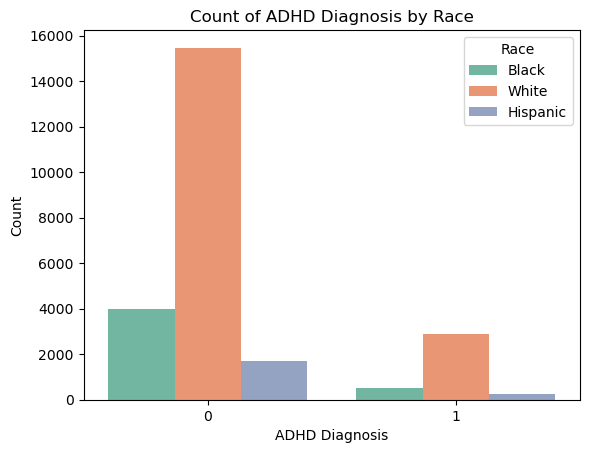

In [226]:
sns.countplot(x='adhd', data=df3, hue='race', palette='Set2')

# Set labels and title
plt.xlabel('ADHD Diagnosis')
plt.ylabel('Count')
plt.title('Count of ADHD Diagnosis by Race')

# Show plot
plt.legend(title='Race')
plt.show()

In [227]:
df_badblack = df_black[['grades']]

In [228]:
print("#Black:", df_black.shape)
print('# Hispanic:', df_hispanic.shape)
print('# White:', df_white.shape)
print('# Total:', df2.shape)


#Black: (1931, 6)
# Hispanic: (4497, 6)
# White: (18339, 6)
# Total: (28716, 6)


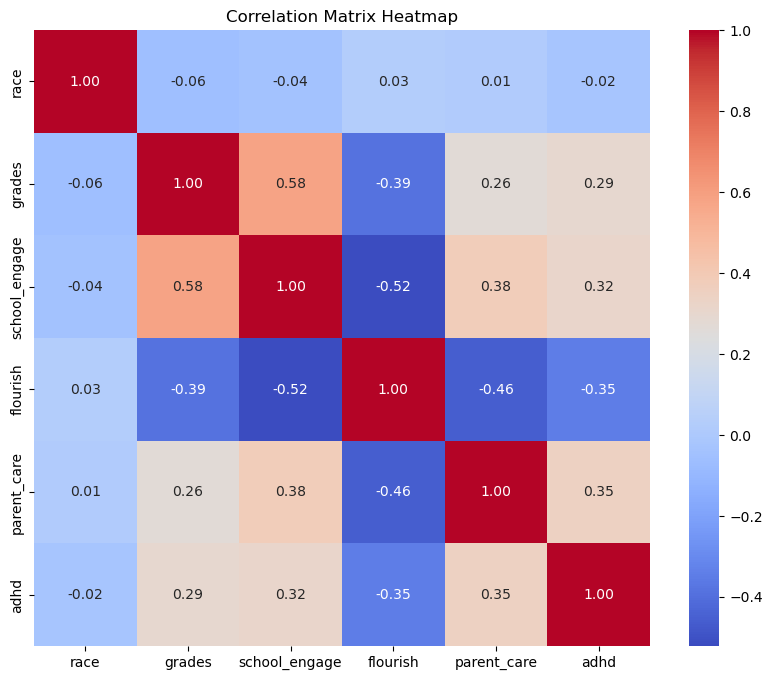

In [229]:

correlation_matrix = df2.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()


In [230]:
X = df_hispanic[['grades', 'school_engage', 'flourish', 'parent_care']]
y = df_hispanic['adhd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)
scaled_X = scaler.fit_transform(X)

model = LogisticRegression()


model.fit(scaled_X_train, y_train)

y_pred = model.predict(scaled_X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

Precision: 0.40476190476190477
Recall: 0.1827956989247312
Accuracy: 0.8877777777777778


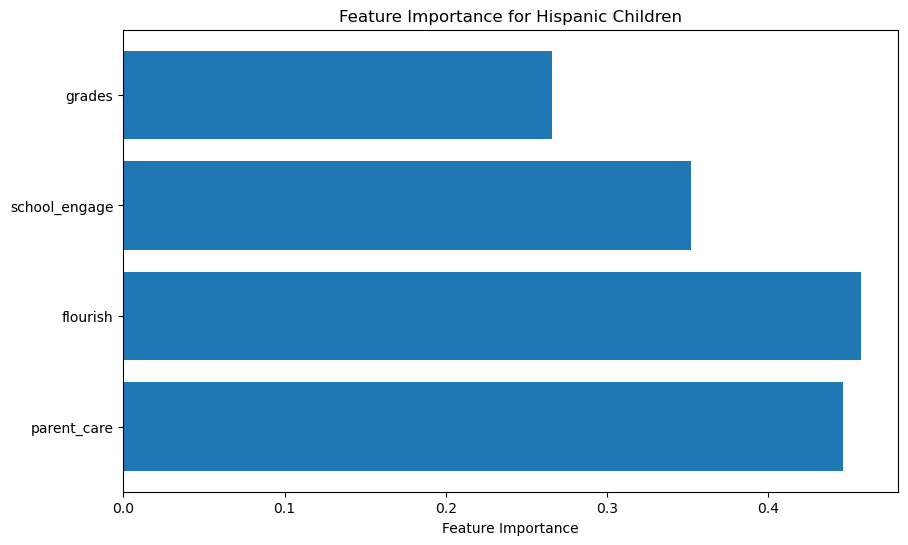

In [231]:
categorical_feature_importance = np.abs(model.coef_)

plt.figure(figsize=(10, 6))
plt.barh(range(len(categorical_feature_importance[0])), categorical_feature_importance[0], align='center')
plt.yticks(np.arange(len(categorical_feature_importance[0])), X)
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Hispanic Children')
plt.gca().invert_yaxis()  
plt.show()

In [232]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       807
           1       0.40      0.18      0.25        93

    accuracy                           0.89       900
   macro avg       0.66      0.58      0.60       900
weighted avg       0.86      0.89      0.87       900



In [233]:
print(confusion_matrix(y_test, y_pred))

[[782  25]
 [ 76  17]]


In [234]:
X = df_black[['grades', 'school_engage', 'flourish', 'parent_care']]
y = df_black['adhd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)
scaled_X = scaler.fit_transform(X)

model = LogisticRegression()


model.fit(scaled_X_train, y_train)

y_pred = model.predict(scaled_X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

Precision: 0.391304347826087
Recall: 0.25
Accuracy: 0.8940568475452196


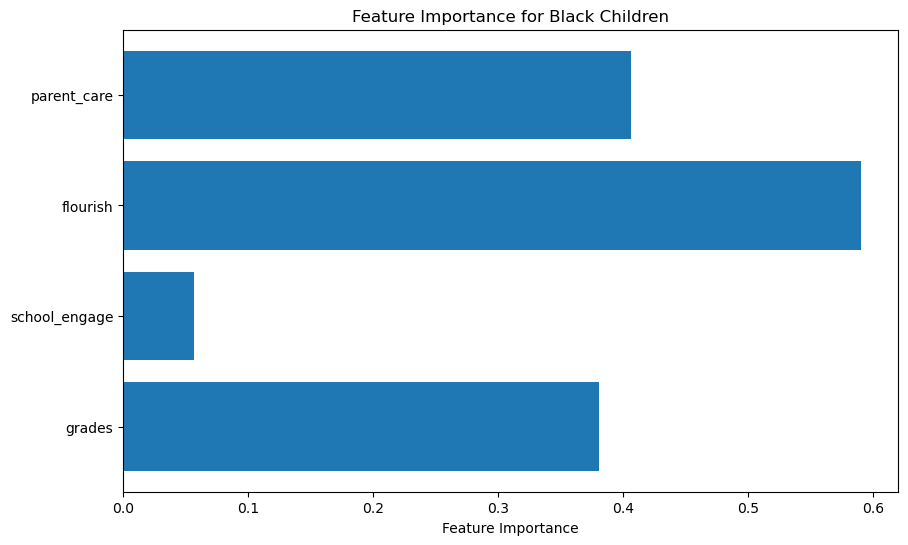

In [235]:
categorical_feature_importance = np.abs(model.coef_)

plt.figure(figsize=(10, 6))
plt.barh(range(len(categorical_feature_importance[0])), categorical_feature_importance[0], align='center')
plt.yticks(np.arange(len(categorical_feature_importance[0])), X)
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Black Children')
plt.show()

In [236]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       351
           1       0.39      0.25      0.31        36

    accuracy                           0.89       387
   macro avg       0.66      0.61      0.62       387
weighted avg       0.88      0.89      0.88       387



In [237]:
print(confusion_matrix(y_test, y_pred))

[[337  14]
 [ 27   9]]


In [238]:
X = df_white[['grades', 'school_engage', 'flourish', 'parent_care']]
y = df_white['adhd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=42)

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)
scaled_X = scaler.fit_transform(X)

model = LogisticRegression()


model.fit(scaled_X_train, y_train)

y_pred = model.predict(scaled_X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

Precision: 0.6538461538461539
Recall: 0.3695652173913043
Accuracy: 0.896457765667575


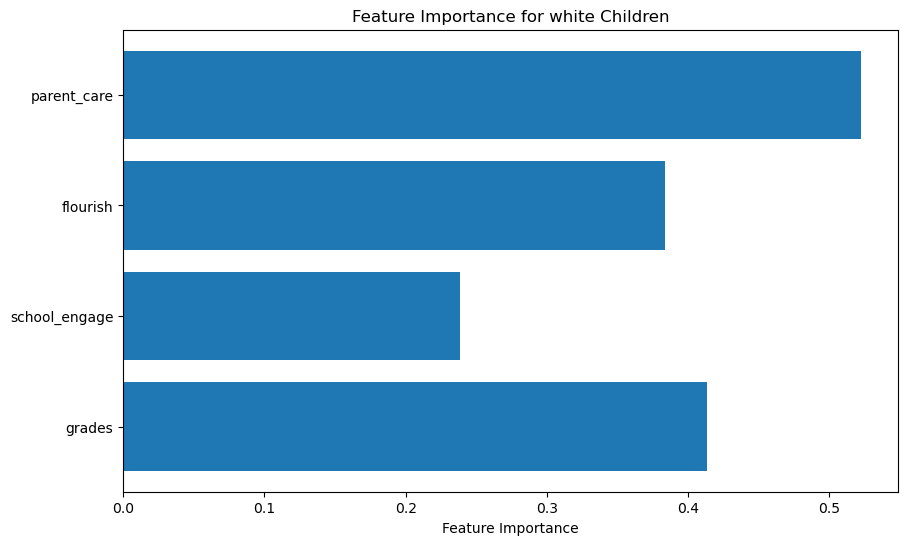

In [239]:
categorical_feature_importance = np.abs(model.coef_)

plt.figure(figsize=(10, 6))
plt.barh(range(len(categorical_feature_importance[0])), categorical_feature_importance[0], align='center')
plt.yticks(np.arange(len(categorical_feature_importance[0])), X)
plt.xlabel('Feature Importance')
plt.title('Feature Importance for white Children')
plt.show()

In [240]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       321
           1       0.65      0.37      0.47        46

    accuracy                           0.90       367
   macro avg       0.78      0.67      0.71       367
weighted avg       0.88      0.90      0.88       367



In [241]:
print(confusion_matrix(y_test, y_pred))

[[312   9]
 [ 29  17]]


In [242]:
X = df2[[ 'grades','school_engage', 'flourish', 'parent_care']]
y = df2['adhd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)
scaled_X = scaler.fit_transform(X)

model = LogisticRegression()


model.fit(scaled_X_train, y_train)

y_pred = model.predict(scaled_X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

Precision: 0.570694087403599
Recall: 0.2723926380368098
Accuracy: 0.8676880222841226


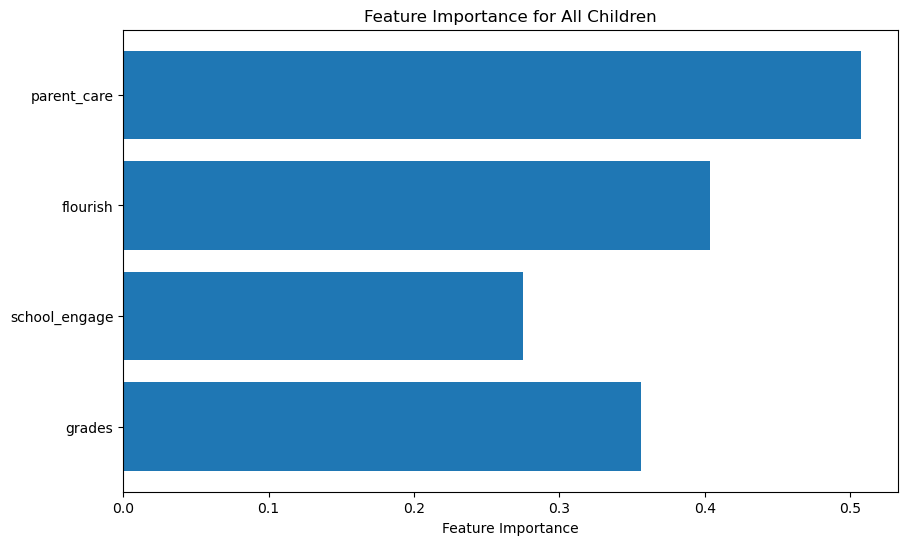

In [243]:
categorical_feature_importance = np.abs(model.coef_)

plt.figure(figsize=(10, 6))
plt.barh(range(len(categorical_feature_importance[0])), categorical_feature_importance[0], align='center')
plt.yticks(np.arange(len(categorical_feature_importance[0])), X)
plt.xlabel('Feature Importance')
plt.title('Feature Importance for All Children')
plt.show()

In [244]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      4929
           1       0.57      0.27      0.37       815

    accuracy                           0.87      5744
   macro avg       0.73      0.62      0.65      5744
weighted avg       0.84      0.87      0.85      5744



In [245]:
print(confusion_matrix(y_test, y_pred))

[[4762  167]
 [ 593  222]]


In [246]:
X = df2[['grades', 'school_engage', 'flourish', 'parent_care']].values
y = df2['adhd'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)


knn = KNeighborsClassifier(n_neighbors=16)
knn.fit(scaled_X_train, y_train)

y_pred = knn.predict(scaled_X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

Precision: 0.5391304347826087
Recall: 0.3042944785276074
Accuracy: 0.8643802228412256


In [247]:
train_accuracies = {}
test_accuracies = {}
neighbors = np.arange(1, 26)

for neighbor in neighbors:
    knn = KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(X_train, y_train)
    train_accuracies[neighbor] = knn.score(X_train, y_train)
    test_accuracies[neighbor] = knn.score(X_test, y_test)

print("Train Accuracies:", train_accuracies)
print("Test Accuracies:", test_accuracies)

Train Accuracies: {1: 0.8253526031690754, 2: 0.8614400139300017, 3: 0.8475970746996343, 4: 0.8558244819780603, 5: 0.8557809507226188, 6: 0.85643391955424, 7: 0.8568692321086541, 8: 0.8640518892564861, 9: 0.8617447327180916, 10: 0.8646177955772244, 11: 0.8642695455336932, 12: 0.8657931394741424, 13: 0.8698415462301933, 14: 0.8701027337628418, 15: 0.8699721399965175, 16: 0.8703639212954901, 17: 0.8720181090022636, 18: 0.8697980149747518, 19: 0.8719310464913808, 20: 0.8722792965349121, 21: 0.8721922340240292, 22: 0.8701462650182832, 23: 0.8697980149747518, 24: 0.8703639212954901, 25: 0.8718004527250566}
Test Accuracies: {1: 0.8154596100278552, 2: 0.8527158774373259, 3: 0.8422701949860725, 4: 0.8487116991643454, 5: 0.8455779944289693, 6: 0.8501044568245125, 7: 0.8476671309192201, 8: 0.8582869080779945, 9: 0.8548050139275766, 10: 0.8603760445682451, 11: 0.8575905292479109, 12: 0.8598537604456824, 13: 0.862116991643454, 14: 0.8643802228412256, 15: 0.8619428969359332, 16: 0.8628133704735376, 

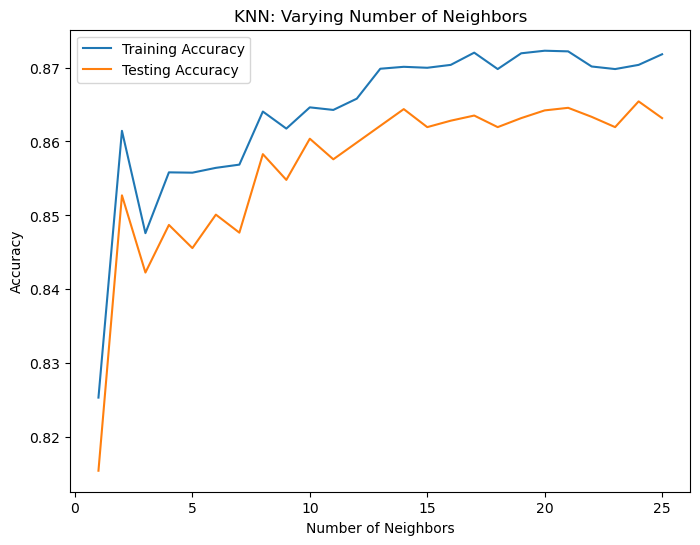

In [248]:
plt.figure(figsize=(8, 6))
plt.title("KNN: Varying Number of Neighbors")
plt.plot(neighbors, train_accuracies.values(), label="Training Accuracy")
plt.plot(neighbors, test_accuracies.values(), label="Testing Accuracy")
plt.legend()
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.show()

In [249]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)
scaled_X = scaler.fit_transform(X)

In [250]:
k = 2 

# Create the k-means model
kmeans = KMeans(n_clusters=k, random_state=42)

# Fit the model to the scaled data
kmeans.fit(scaled_X)

# Get cluster labels for each data point
cluster_labels = kmeans.labels_

# Add cluster labels to the DataFrame
df2['cluster'] = cluster_labels

# Print the count of data points in each cluster
print(df2['cluster'].value_counts())

cluster_centroids = pd.DataFrame(kmeans.cluster_centers_, columns=['grades', 'school_engage', 'flourish', 'parent_care'])
print(cluster_centroids)

C:\Users\dell\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


cluster
1    20231
0     8485
Name: count, dtype: int64
     grades  school_engage  flourish  parent_care
0  0.875907       1.080947 -1.156235     0.839891
1 -0.367361      -0.453356  0.484932    -0.352255


In [251]:
# Merge cluster assignments with ADHD diagnosis column
merged_data = pd.concat([df2, pd.get_dummies(df2['adhd'])], axis=1)

# Calculate percentage of ADHD diagnosis in each cluster
adhd_percentage = merged_data.groupby('cluster').mean()[1] * 100

print(adhd_percentage)

cluster
0    33.541544
1     5.812861
Name: 1, dtype: float64


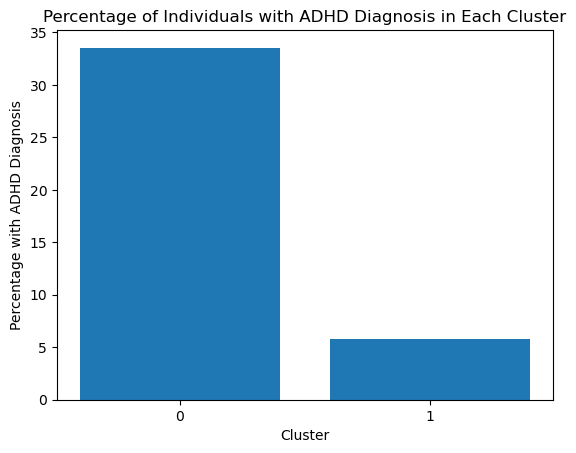

In [252]:
plt.bar(adhd_percentage.index, adhd_percentage.values)
plt.xlabel('Cluster')
plt.ylabel('Percentage with ADHD Diagnosis')
plt.title('Percentage of Individuals with ADHD Diagnosis in Each Cluster')
plt.xticks(adhd_percentage.index)
plt.show()

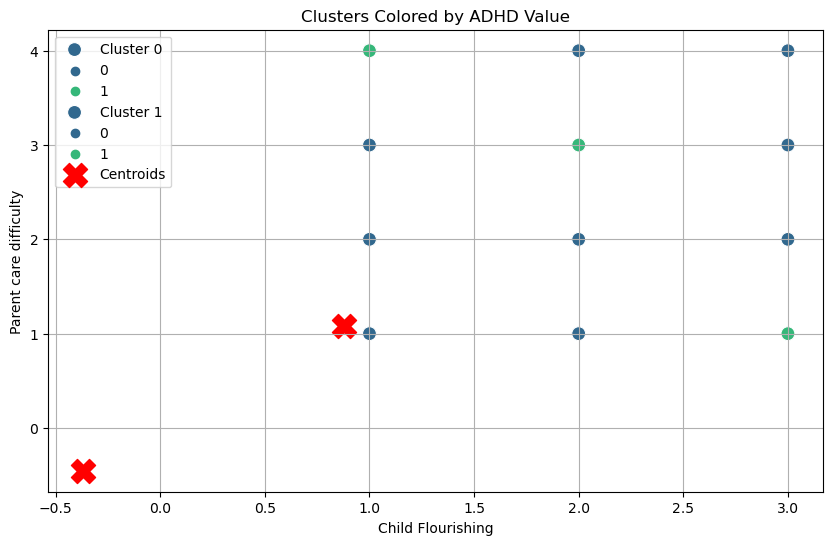

In [253]:
plt.figure(figsize=(10, 6))

# Scatter plot for each cluster
for cluster_num in range(k):
    cluster_data = df2[df2['cluster'] == cluster_num]
    sns.scatterplot(x='flourish', y='parent_care', hue='adhd', data=cluster_data, palette='viridis', s=100, edgecolor='w', label=f'Cluster {cluster_num}')

# Plot centroids
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X', label='Centroids')

plt.title('Clusters Colored by ADHD Value')
plt.xlabel('Child Flourishing')
plt.ylabel('Parent care difficulty')
plt.legend()
plt.grid(True)
plt.show()


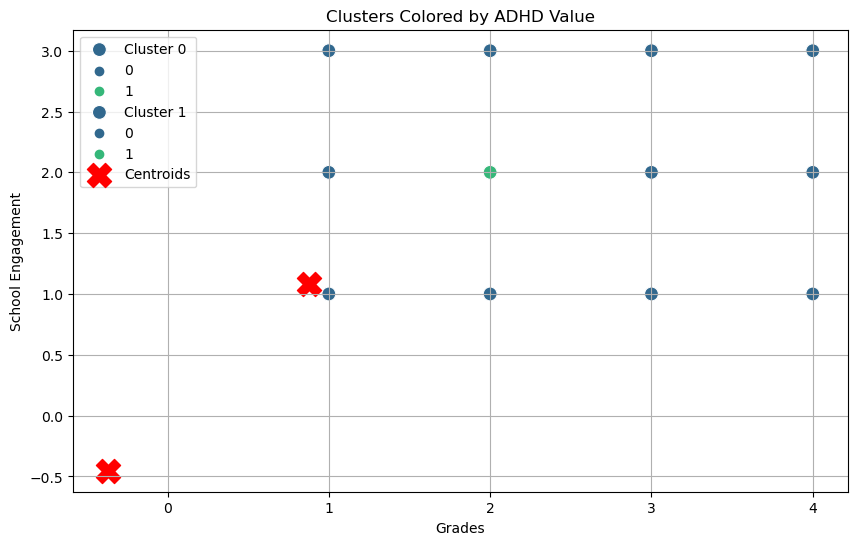

In [254]:
# Plot the clusters and color by 'adhd' values
plt.figure(figsize=(10, 6))

# Scatter plot for each cluster
for cluster_num in range(k):
    cluster_data = df2[df2['cluster'] == cluster_num]
    sns.scatterplot(x='grades', y='school_engage', hue='adhd', data=cluster_data, palette='viridis', s=100, edgecolor='w', label=f'Cluster {cluster_num}')

# Plot centroids
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X', label='Centroids')

plt.title('Clusters Colored by ADHD Value')
plt.xlabel('Grades')
plt.ylabel('School Engagement')
plt.legend()
plt.grid(True)
plt.show()


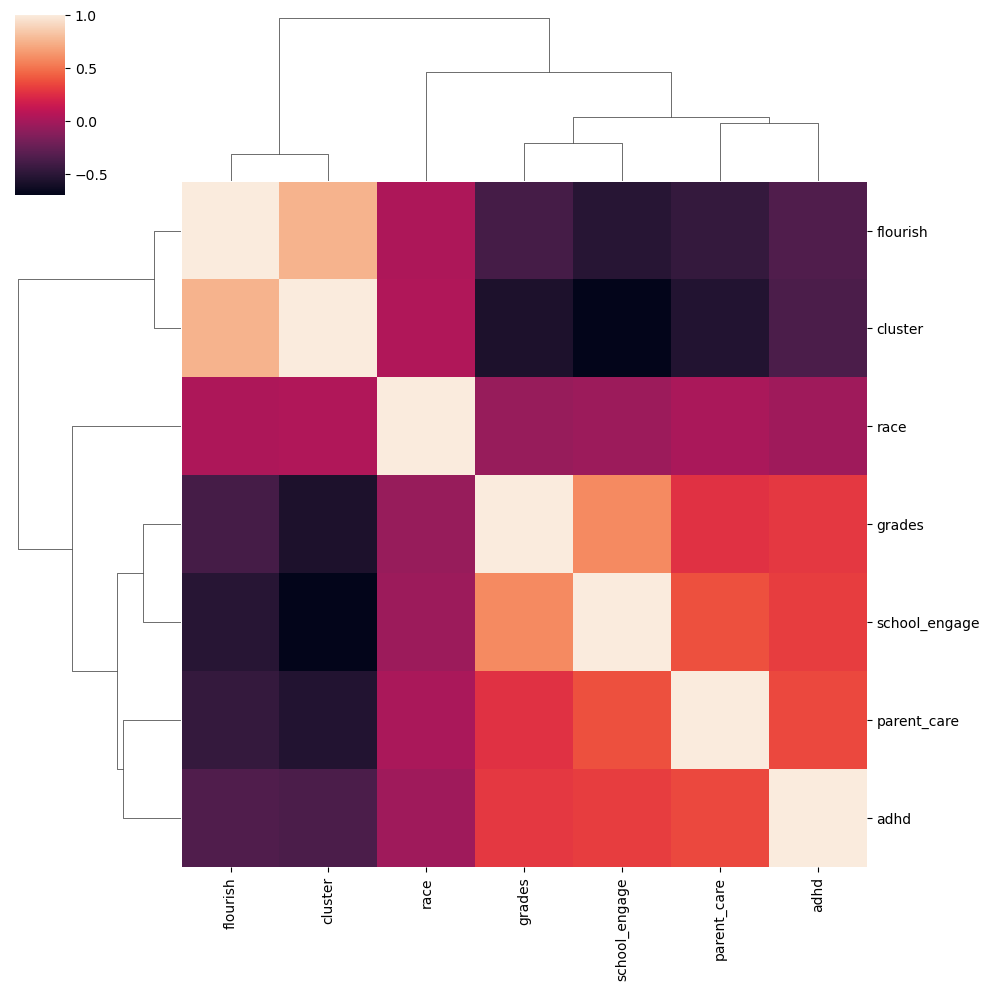

In [255]:
sns.clustermap(df2.corr())